# 映画のレビューの感情分析

## 【ライブラリのインポート】

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

%matplotlib inline
sns.set_style("whitegrid")
# plt.style.use("fivethirtyeight")

from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# CounterVectorizerをインスタンス化する。
vect = CountVectorizer()

### 目的変数について
解析されたフレーズごとに分類精度（正しく予測されたラベルの割合）で評価される。<br>
0:否定的<br>
1:やや否定的<br>
2:中立<br>
3:やや肯定的<br>
4:肯定的

### 提出形式について
テストセット内の各フレーズについて、感情のラベルを予測する。<br>
**PhraseID, Sentiment**という形式で提出する。

## 【データセットをpandasで読みこむ。】

In [3]:
train_df = pd.read_csv("train.tsv", delimiter='\t')
test_df = pd.read_csv("test.tsv", delimiter='\t')

In [4]:
train_df[train_df['Phrase'].isnull()]

,PhraseId,SentenceId,Phrase,Sentiment


In [5]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


#### 欠損値の確認
欠損値のあるデータを見てたところ、欠損値は存在しなかった。
（ちなみに、欠損値が存在する行を削除する手法を、「リストワイズ法」という。<br>
これは、訓練データにのみ使用することができる。<br>
訓練データの削除は「削除したデータは学習に使用しない」と捉えることができるが、<br>テストデータは予測しなければならないデータなので、削除を行なった場合は、欠損値をもつサンプルに対する予測を破棄することになり、望ましくない。

In [6]:
train_df.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

## 【探索的データ分析】

・スコア「２」のレビューが多かった（「中立」的なレビュー）<br>
・同一なレビューは無い。（freq=1だから）

In [7]:
train_df.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


In [8]:
train_df.describe(exclude='number')

,Phrase
count,156060
unique,156060
top,A series of escapades demonstrating the adage ...
freq,1


文字数を算出してみる。

In [9]:
train_df['Phrase_len'] = train_df.Phrase.apply(len)
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment,Phrase_len
0,1,1,A series of escapades demonstrating the adage ...,1,188
1,2,1,A series of escapades demonstrating the adage ...,2,77
2,3,1,A series,2,8
3,4,1,A,2,1
4,5,1,series,2,6


In [10]:
# # plt.figure(figsize=(12, 8), dpi=600)
# fig, ax = plt.subplots(2, 3, figsize=(12, 8), dpi=600)
# plt.subplots_adjust(wspace=0.3, hspace=0.2)
# plt.xlabel("Phrase Length")

# train_df[train_df.Sentiment==0].Phrase_len.plot(ax=ax[0,0], kind='hist', label='sentiment', alpha=0.6, legend=True)
# train_df[train_df.Sentiment==1].Phrase_len.plot(ax=ax[0,1], kind='hist', label='sentiment', alpha=0.6, legend=True)
# train_df[train_df.Sentiment==2].Phrase_len.plot(ax=ax[0,2], kind='hist', label='sentiment', alpha=0.6, legend=True)
# train_df[train_df.Sentiment==3].Phrase_len.plot(ax=ax[1,0], kind='hist', label='sentiment', alpha=0.6, legend=True)
# train_df[train_df.Sentiment==4].Phrase_len.plot(ax=ax[1,1], kind='hist', label='sentiment', alpha=0.6, legend=True)

# plt.legend()
# plt.xlabel("Phrase Length")

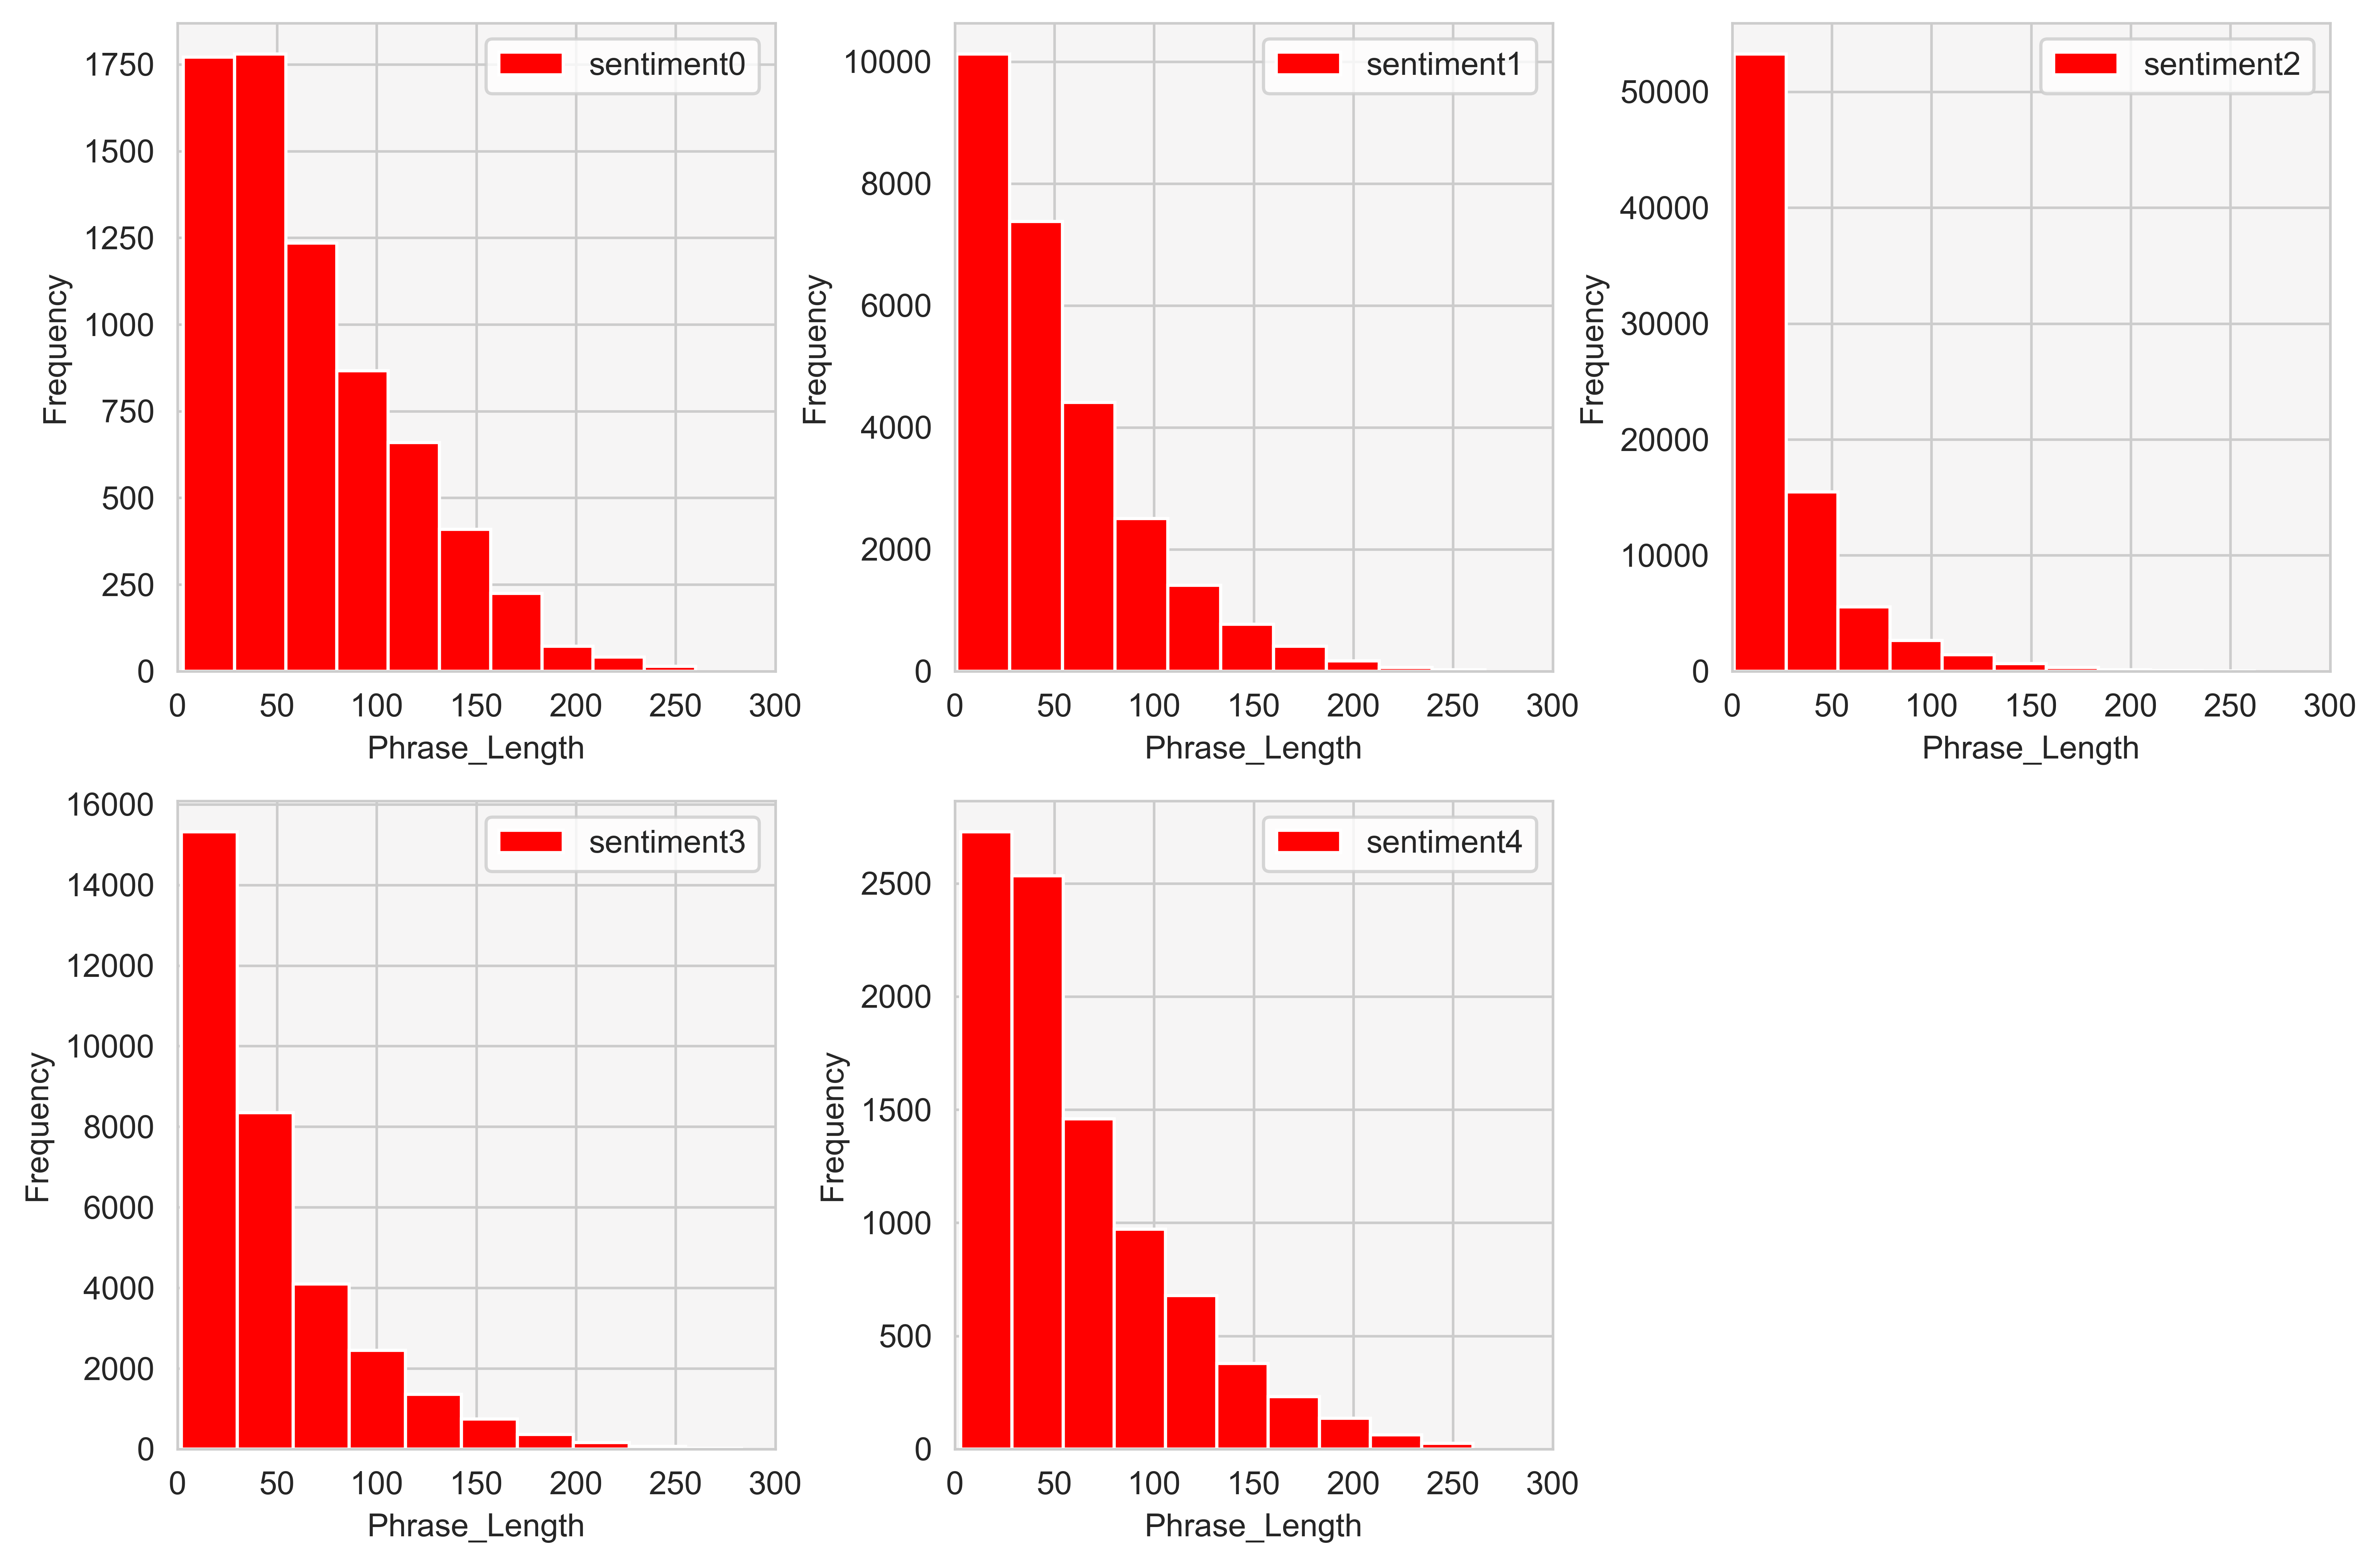

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8), dpi=600)
plt.subplots_adjust(wspace=0.3, hspace=0.2)

background_color = "#f6f5f5"

run_no = 0
for row in range(0,2):
    for col in range(0, 3):
        locals()["ax"+str(run_no)] = train_df[train_df.Sentiment==run_no].Phrase_len.plot(ax=ax[row, col], kind='hist', label='sentiment'+str(run_no), legend=True, color="red")
        locals()["ax"+str(run_no)].set_xlabel("Phrase_Length")
        locals()["ax"+str(run_no)].set_xlim(0, 300)
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        run_no += 1

ax5.remove()
plt.show()

・分布の形は大体同じ。<br>
　└文が短いレビューほど多い。<br>
　└５０文字以内がほとんど。<br>
・中立的なレビューの数が多い。

In [12]:
# fig = plt.figure(figsize=(12, 8), dpi=600)
# plt.subplots_adjust(wspace=0.3, hspace=0.2)

# ax0 = fig.add_subplot(231)
# train_df[train_df.Sentiment==0].Phrase_len.plot(kind='hist', color='blue', label='sentiment=0', alpha=0.6, legend=True)
# ax0.set_xlabel("Phrase Length")

# ax1 = fig.add_subplot(232)
# train_df[train_df.Sentiment==1].Phrase_len.plot(kind='hist', color='red', label='sentiment=1', alpha=0.6, legend=True)
# ax1.set_xlabel("Phrase Length")

# ax2 = fig.add_subplot(233)
# train_df[train_df.Sentiment==2].Phrase_len.plot(kind='hist', color='yellow', label='sentiment=2', alpha=0.6, legend=True)
# ax2.set_xlabel("Phrase Length")

# ax3 = fig.add_subplot(234)
# train_df[train_df.Sentiment==3].Phrase_len.plot(kind='hist', color='green', label='sentiment=3', alpha=0.6, legend=True)
# ax3.set_xlabel("Phrase Length")

# ax4 = fig.add_subplot(235)
# train_df[train_df.Sentiment==4].Phrase_len.plot(kind='hist', color='pink', label='sentiment=4', alpha=0.6, legend=True)
# ax4.set_xlabel("Phrase Length")

# テキストの前処理

In [13]:
import string
from nltk.corpus import stopwords

def text_process(mess):
    # 句読点を除去
    # ストップワード除去
    # 削除されたテキストのリストを返す。
    
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    
    # 句読点が文字の中にあるかどうかチェックする。
    nopunc = [char for char in mess if char not in string.punctuation]
    
    # 再び文字を結そうして、文字列を形成する。
    nopunc = ''.join(nopunc)
    
    # ストップワードを削除する。
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [14]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment,Phrase_len
0,1,1,A series of escapades demonstrating the adage ...,1,188
1,2,1,A series of escapades demonstrating the adage ...,2,77
2,3,1,A series,2,8
3,4,1,A,2,1
4,5,1,series,2,6


In [15]:
train_df['Clean_Phrase'] = train_df.Phrase.apply(text_process)

In [16]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment,Phrase_len,Clean_Phrase
0,1,1,A series of escapades demonstrating the adage ...,1,188,series escapades demonstrating adage good goos...
1,2,1,A series of escapades demonstrating the adage ...,2,77,series escapades demonstrating adage good goose
2,3,1,A series,2,8,series
3,4,1,A,2,1,
4,5,1,series,2,6,series


【疑問点】<br>
短すぎるレビューは除去してしまった方がいいのでは？<br>
短すぎる文章(１０文字以下くらい)が、Sentimetが「2」に分類されているから、Sentiment「2」のデータが多いのでは？

In [17]:
# train_df[train_df.Phrase_len < 10].head(10000)
# # ここで、head()の引数を調整して多くのデータを見てみたが、単語1つで意味が理解できないものが多く、それらはSentimentが[2]に分類されていた。

In [18]:
train_df[train_df.Phrase_len < 20].count()

PhraseId        59370
SentenceId      59370
Phrase          59370
Sentiment       59370
Phrase_len      59370
Clean_Phrase    59370
dtype: int64

## ベクトル化

レビューをベクトル化して、機械学習が理解できるように調整する。
1, ある単語が各メッセージに何回出現しているか数える。
2, 頻出たんごが低くなるように重み付けをする。
3, ベクトルを単位長に正規化し、元のテキストの長さを抽象化する。（L2ノルム）

In [19]:
# この部分は、ヒントを得た
# train_dfのデータから、XとYを作成。
# ２を超えるSentimentの値は1, それ以外は0とする。
X = train_df["Phrase"]
Y = train_df["Sentiment"].apply(lambda i: 0 if i <= 2 else 1)
print(X.shape)
print(Y.shape)

(156060,)
(156060,)


In [20]:
Y.value_counts()

0    113927
1     42133
Name: Sentiment, dtype: int64

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(117045,)
(39015,)
(117045,)
(39015,)


In [22]:
X_train.head()

143442                       called any kind of masterpiece
150472    will be Greek to anyone not predisposed to the...
37167                                     star performances
68485                              however well intentioned
29185                sensitive , smart , savvy , compelling
Name: Phrase, dtype: object

In [23]:
X_test.head()

78734                                               Bad and
126189    It 's a stale , overused cocktail using the sa...
132845                                          of the gags
126239                                          get to know
30608     , High Crimes would be entertaining , but forg...
Name: Phrase, dtype: object

In [24]:
y_train.head()

143442    0
150472    0
37167     1
68485     0
29185     1
Name: Sentiment, dtype: int64

In [25]:
y_test.head()

78734     0
126189    0
132845    0
126239    0
30608     0
Name: Sentiment, dtype: int64

カウントベクトライザーに学習させる

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer()

In [27]:
# 学習データの単語を学習し、それを用いて文書用語マトリクスを作成する。
X_train_dtm = vect.fit_transform(X_train)

In [28]:
X_train_dtm

<117045x15223 sparse matrix of type '<class 'numpy.int64'>'
	with 728954 stored elements in Compressed Sparse Row format>

In [29]:
# テストデータを文書用語マトリクスに変換する。
X_test_dtm = vect.transform(X_test)

In [30]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<117045x15223 sparse matrix of type '<class 'numpy.float64'>'
	with 728954 stored elements in Compressed Sparse Row format>

## モデル評価

In [31]:
# ナイーブベイズ・・・二項分布、多項分布に基づいたイベントモデル。文書データの分類に用いられる手法。

from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [32]:
# X_train_dtmを用いたモデルの学習(IPythonのマジックコマンドでタイミングを合わせる。）
%time nb.fit(X_train_dtm, y_train)
# 学習用のデータと結果を学習。

# マジックコマンド・・・Jupyter notebook内で利用可能なコマンド。マジックコマンドを利用するには、先頭に%または%%を入力する。
# %timeを入力するとラインマジックコマンド隣、その行の実行時間を計測する。

CPU times: user 32.3 ms, sys: 5.01 ms, total: 37.3 ms
Wall time: 49.1 ms


MultinomialNB()

In [33]:
# X_test_dtmのクラス予測を行う。
y_pred_class = nb.predict(X_test_dtm)
# テストデータによる予測

In [34]:
# クラス予測の精度を計算する。
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)
# Accuracy(正解率）= (TP + TN) / (TP + TN + FP + FN)・・・本来ポジティブに分類すべき項目をポジティブに分類し、ネガティブに分類すべき項目をネガティブに分類できた割合。
# metrics.accuracy_scoreは計算用のメソッド。
# TP・・・真陽性。スパムに分類すべきメールをスパムに正しく分類できた件数
# TN・・・真陰性。スパムではないと分類すべきメールをスパムではないと正しく分類できた件数
# FP・・・偽陽性。スパムではないと分類すべきメールをスパムのフォルダに誤って分類した件数を指す。
# FN・・・偽陰性。スパムに分類すべきメールをスパムではないフォルダに誤って分類した件数

0.8234268870947071

In [35]:
# 混合行列を表示する。

metrics.confusion_matrix(y_test, y_pred_class)
# 混合行列・・・クラス分類問題の結果を「実際のクラス」と「予測したクラス」を軸にしてまとめたもの。
# array([[TN, FP],
#        [FN, TP]])

array([[25346,  3198],
       [ 3691,  6780]])

In [36]:
# X_test_dtmの予測確率を計算する (キャリブレーションが不十分)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([8.05763369e-02, 5.45398671e-05, 1.08682816e-01, ...,
       9.87075454e-01, 6.75922900e-02, 5.47574766e-01])

In [37]:
metrics.roc_auc_score(y_test, y_pred_prob)
# AUC・・・Area under the cerve。ROC曲線を作成した時に、グラフの曲線より下の部分の面積をAUCという。
# 0から1までの値をとり、値が1に近いほど判別能が高いことを示す。判別能がランダムであるとき、AUC = 0.5となる。

0.8424644386717446

In [38]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])
pipe.fit(X_train, y_train)

# piplineモジュールでパイプラインの作成を行なっている。
# └いくつかの前処理を実行しているような場合にも、fitやpredictをパイプラインに対して１度だけ呼べば良く便利。
# └パイプラインに対してgrid searchする際、パラメータを１度に指定でき、利便性が高い、fitを読んだ後の変換器をキャッシュでき、性能向上が期待できる場合がある。
# transformer(変換を担う）とestimator（学習を担う）に同じデータが使用されるため、CVの際にデータがリークする不具合を防げる。

# Pipelineのstep引数に、名前とtransformerもしくはestimatorのタプルのリストを渡す。

Pipeline(steps=[('bow', CountVectorizer()), ('tfid', TfidfTransformer()),
                ('model', MultinomialNB())])

In [39]:
y_pred = pipe.predict(X_test)
# データフレームをpipeに突っ込む。

In [40]:
metrics.accuracy_score(y_test, y_pred)

0.8205305651672433

In [41]:
metrics.confusion_matrix(y_test, y_pred)

array([[27095,  1449],
       [ 5553,  4918]])

# 提出ファイルの作成

In [48]:
y_pred = pd.DataFrame(y_pred, columns=['Sentiment'])

In [49]:
X_test = pd.DataFrame(X_test, columns=['Phrase'])

In [47]:
y_pred.head()

,Sentiment
0,0
1,0
2,0
3,0
4,0


In [56]:
X_test.head()

,Phrase
78734,Bad and
126189,"It 's a stale , overused cocktail using the sa..."
132845,of the gags
126239,get to know
30608,", High Crimes would be entertaining , but forg..."


In [68]:
output =pd.DataFrame({'PhraseId': X_test.index,
                      'Sentiment': y_pred.Sentiment})
output.to_csv('submission.csv', index=False)

In [69]:
submission_data = pd.read_csv("submission.csv")
submission_data.head()

,PhraseId,Sentiment
0,78734,0
1,126189,0
2,132845,0
3,126239,0
4,30608,0


In [70]:
print(len(submission_data))

39015


In [71]:
test_df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
